# Peut-on prédire la qualité d'un vin à partir de ses composants chimiques ?

### Import des librairies

In [1578]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA

## Objectif 1 : arriver à prédire la qualité d'un vin
### Import du dataset 

In [1579]:
wine = pd.read_csv('winequality-red.csv')

In [1580]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Etude du dataset

In [1581]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


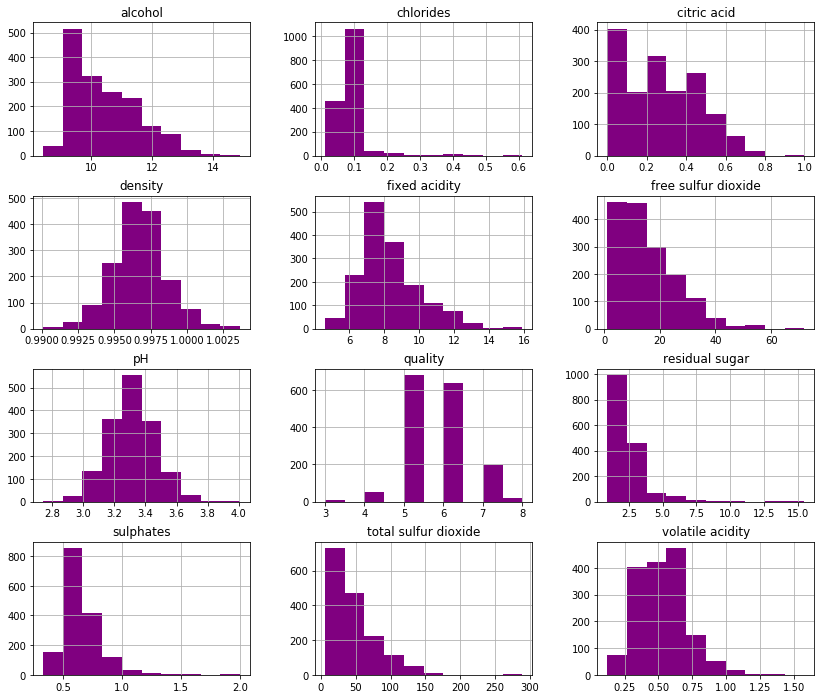

In [1582]:
wine.hist(figsize=(14,12), color="purple")
plt.savefig('histograms_wines.png')
plt.show()

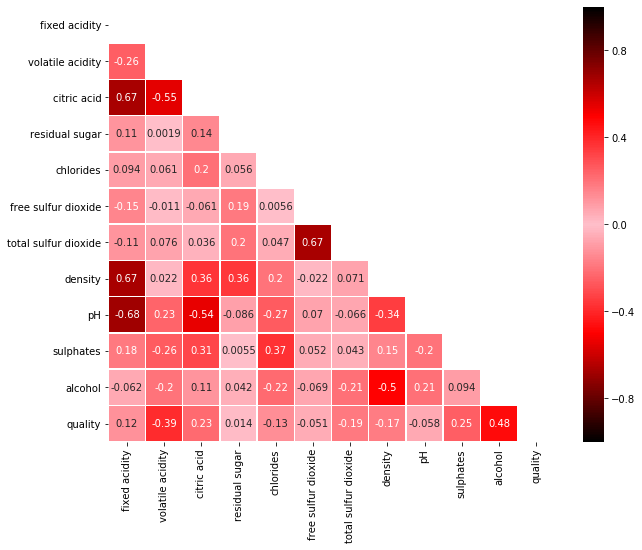

In [1583]:
wine_corr = wine.corr()
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['black','red','pink','red','black'])
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(wine_corr, xticklabels=wine_corr.columns, yticklabels=wine_corr.columns, cmap=cmap,linewidths = .5, annot=True, ax=ax, mask=mask, vmin=-1)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('correlation_table_wine.png')
plt.show()

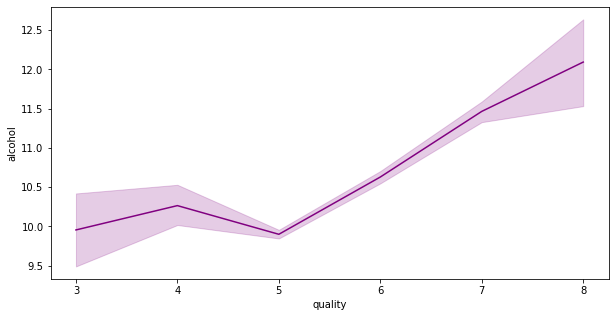

In [1584]:
f, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x="quality", y="alcohol", data=wine, color='purple')
plt.savefig('alcohol_vs_quality.png')

Pas besoin de feature enginering car les données sont toutes numériques et nécessaires (pas de corrélation entre elles supérieures à 70%)

### Scalling et split

In [1585]:
X = wine.drop(columns = ['quality'])
y = wine['quality']

In [1586]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [1587]:
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train0, y_train0, test_size=0.25, random_state=1)

In [1588]:
X_train.shape

(959, 11)

In [1589]:
X_dev.shape

(320, 11)

In [1590]:
X_test.shape

(320, 11)

### Modèles et prédictions

#### Linear SVC 

In [1591]:
linearsvc = LinearSVC(dual=False)
linearsvc.fit(X_train,y_train)
pred_svc=linearsvc.predict(X_dev)

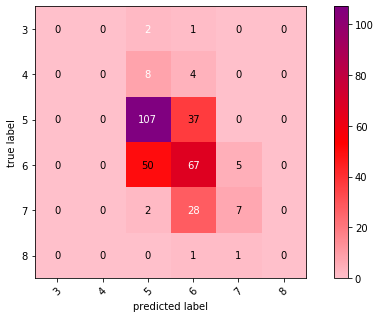

In [1592]:
cmap2 = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['pink','red','purple'])
cm = confusion_matrix(y_dev, pred_svc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj1_SVC.png')
plt.show()

In [1593]:
print('Accuracy score :',accuracy_score(y_dev, pred_svc))

Accuracy score : 0.565625


In [1594]:
svc_eval = cross_val_score(estimator = linearsvc, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation (accuracy) :',svc_eval.mean())

Cross validation (accuracy) : 0.5871297099534271


In [1595]:
print('F1 score :\n',classification_report(y_dev, pred_svc, digits=3))

F1 score :
               precision    recall  f1-score   support

           3      0.000     0.000     0.000         3
           4      0.000     0.000     0.000        12
           5      0.633     0.743     0.684       144
           6      0.486     0.549     0.515       122
           7      0.538     0.189     0.280        37
           8      0.000     0.000     0.000         2

    accuracy                          0.566       320
   macro avg      0.276     0.247     0.247       320
weighted avg      0.532     0.566     0.537       320



C:\Users\aline\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### RandomForest 

In [1596]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_dev)

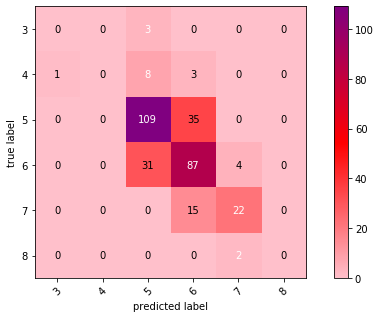

In [1597]:
cm = confusion_matrix(y_dev, pred_rfc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj1_RFC.png')
plt.show()

In [1598]:
print('Accuracy score :',accuracy_score(y_dev, pred_rfc))

Accuracy score : 0.68125


In [1599]:
rfc_eval = cross_val_score(estimator = rfc, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation (accuracy):',rfc_eval.mean())

Cross validation (accuracy): 0.6739428936100131


In [1600]:
print('F1 score:\n',classification_report(y_dev, pred_rfc, digits=3))

F1 score:
               precision    recall  f1-score   support

           3      0.000     0.000     0.000         3
           4      0.000     0.000     0.000        12
           5      0.722     0.757     0.739       144
           6      0.621     0.713     0.664       122
           7      0.786     0.595     0.677        37
           8      0.000     0.000     0.000         2

    accuracy                          0.681       320
   macro avg      0.355     0.344     0.347       320
weighted avg      0.653     0.681     0.664       320



C:\Users\aline\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### XGBoost

In [1601]:
xgboost = XGBClassifier(objective='multi:softmax', num_class=10, n_jobs=-1,booster="gbtree",tree_method = "hist",grow_policy = "lossguide")
xgboost.fit(X_train, y_train)
pred_xgboost = xgboost.predict(X_dev)

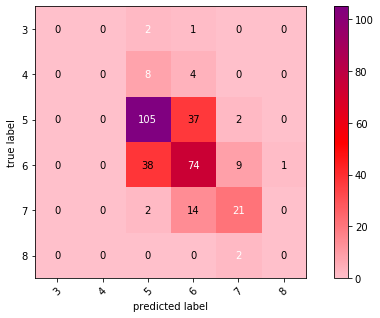

In [1602]:
cm = confusion_matrix(y_dev, pred_xgboost)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj_XGBoost.png')
plt.show()

In [1603]:
print('Accuracy score :',accuracy_score(y_dev, pred_xgboost))

Accuracy score : 0.625


In [1604]:
xgboost_eval = cross_val_score(estimator = xgboost, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation (accuracy):',xgboost_eval.mean())

Cross validation (accuracy): 0.6411970118270676


In [1605]:
print('F1 score :\n',classification_report(y_dev, pred_xgboost, digits=3))

F1 score :
               precision    recall  f1-score   support

           3      0.000     0.000     0.000         3
           4      0.000     0.000     0.000        12
           5      0.677     0.729     0.702       144
           6      0.569     0.607     0.587       122
           7      0.618     0.568     0.592        37
           8      0.000     0.000     0.000         2

    accuracy                          0.625       320
   macro avg      0.311     0.317     0.314       320
weighted avg      0.593     0.625     0.608       320



C:\Users\aline\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Prédiction avec le meilleur modèle sur X_train complet (Random Forest) 

In [1606]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train0, y_train0)
pred_rfc0 = rfc.predict(X_test)

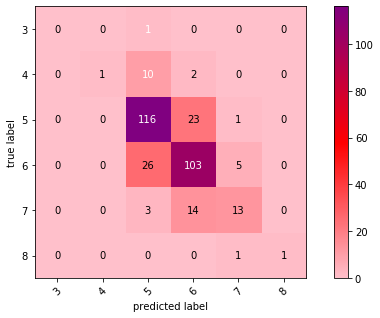

In [1607]:
cm = confusion_matrix(y_test, pred_rfc0)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj1_RFC_test.png')
plt.show()

In [1608]:
print('Accuracy score :',accuracy_score(y_test, pred_rfc0))

Accuracy score : 0.73125


In [1609]:
rfc_eval = cross_val_score(estimator = rfc, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation', rfc_eval.mean())

Cross validation 0.6779047266139657


In [1610]:
print('F1 score :\n',classification_report(y_test, pred_rfc0, digits=3))

F1 score :
               precision    recall  f1-score   support

           3      0.000     0.000     0.000         1
           4      1.000     0.077     0.143        13
           5      0.744     0.829     0.784       140
           6      0.725     0.769     0.746       134
           7      0.650     0.433     0.520        30
           8      1.000     0.500     0.667         2

    accuracy                          0.731       320
   macro avg      0.686     0.435     0.477       320
weighted avg      0.737     0.731     0.714       320



C:\Users\aline\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Objectif 2 : arriver à prédire si un vin est bon ou mauvais (binaire)

In [1611]:
wine = pd.read_csv('winequality-red.csv')
pd.set_option('mode.chained_assignment', None)

### Classement de la colonne 'Quality' en 0 et 1

In [1612]:
wine.quality[wine['quality']<=5]=0
wine.quality[wine['quality']>5]=1

In [1613]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Comme pour l'objectif 1 : pas besoin de feature enginering car les données sont toutes numériques, nécessaires (pas de corrélation entre elles supérieures à 70%)

### Scalling et split

In [1614]:
X = wine.drop(columns = ['quality'])
y = wine['quality']

In [1615]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [1616]:
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train0, y_train0, test_size=0.25, random_state=1)

In [1617]:
X_train.shape

(959, 11)

In [1618]:
X_dev.shape

(320, 11)

In [1619]:
X_test.shape

(320, 11)

### Modèles et prédictions 

#### Linear SVC 

In [1620]:
linearsvc = LinearSVC(dual=False)
linearsvc.fit(X_train,y_train)
pred_svc=linearsvc.predict(X_dev)

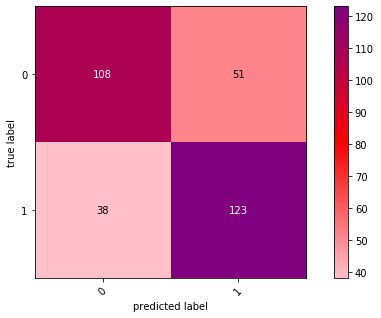

In [1621]:
cmap2 = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['pink','red','purple'])
cm = confusion_matrix(y_dev, pred_svc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj2_SVC.png')
plt.show()

In [1622]:
print('Accuracy score :',accuracy_score(y_dev, pred_svc))

Accuracy score : 0.721875


In [1623]:
svc_eval = cross_val_score(estimator = linearsvc, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation (accuracy) :',svc_eval.mean())

Cross validation (accuracy) : 0.7443229166666667


In [1624]:
print('F1 score :\n',classification_report(y_dev, pred_svc, digits=3))

F1 score :
               precision    recall  f1-score   support

           0      0.740     0.679     0.708       159
           1      0.707     0.764     0.734       161

    accuracy                          0.722       320
   macro avg      0.723     0.722     0.721       320
weighted avg      0.723     0.722     0.721       320



#### RandomForest 

In [1625]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_dev)

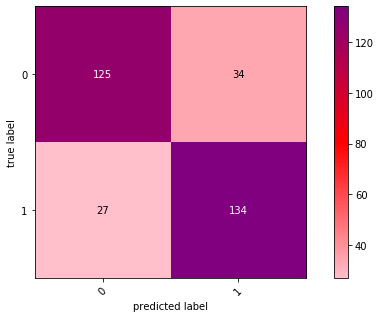

In [1626]:
cm = confusion_matrix(y_dev, pred_rfc)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj2_RFC.png')
plt.show()

In [1627]:
print('Accuracy score :',accuracy_score(y_dev, pred_rfc))

Accuracy score : 0.809375


In [1628]:
rfc_eval = cross_val_score(estimator = rfc, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation (accuracy):',rfc_eval.mean())

Cross validation (accuracy): 0.8045312499999999


In [1629]:
print('F1 score:\n',classification_report(y_dev, pred_rfc, digits=3))

F1 score:
               precision    recall  f1-score   support

           0      0.822     0.786     0.804       159
           1      0.798     0.832     0.815       161

    accuracy                          0.809       320
   macro avg      0.810     0.809     0.809       320
weighted avg      0.810     0.809     0.809       320



#### XGBoost

In [1630]:
xgboost = XGBClassifier(objective='multi:softmax', num_class=10, n_jobs=-1,booster="gbtree",tree_method = "hist",grow_policy = "lossguide")
xgboost.fit(X_train, y_train)
pred_xgboost = xgboost.predict(X_dev)

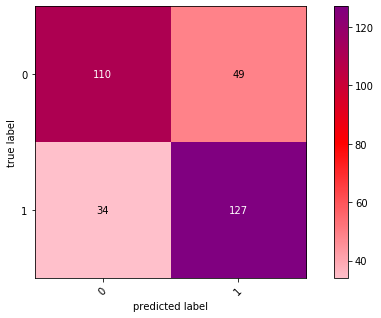

In [1631]:
cm = confusion_matrix(y_dev, pred_xgboost)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj2_XGBoost.png')
plt.show()

In [1632]:
print('Accuracy score :',accuracy_score(y_dev, pred_xgboost))

Accuracy score : 0.740625


In [1633]:
xgboost_eval = cross_val_score(estimator = xgboost, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation (accuracy):',xgboost_eval.mean())

Cross validation (accuracy): 0.778734681372549


In [1634]:
print('F1 score :\n',classification_report(y_dev, pred_xgboost, digits=3))

F1 score :
               precision    recall  f1-score   support

           0      0.764     0.692     0.726       159
           1      0.722     0.789     0.754       161

    accuracy                          0.741       320
   macro avg      0.743     0.740     0.740       320
weighted avg      0.743     0.741     0.740       320



### Prédiction avec le meilleur modèle sur X_train complet (Random Forest) 

In [1635]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train0, y_train0)
pred_rfc0 = rfc.predict(X_test)

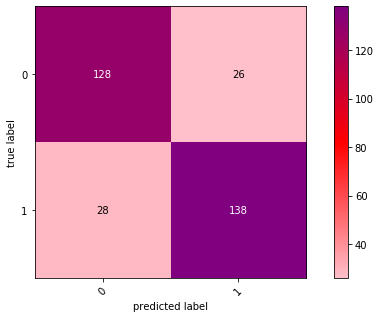

In [1636]:
cm = confusion_matrix(y_test, pred_rfc0)
fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=linearsvc.classes_,figsize=(10, 5), cmap=cmap2, colorbar=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.savefig('confusion_matrix_obj2_RFC_test.png')
plt.show()

In [1637]:
print('Accuracy score :',accuracy_score(y_test, pred_rfc0))

Accuracy score : 0.83125


In [1638]:
rfc_eval = cross_val_score(estimator = rfc, X = X_train0, y = y_train0, cv=5, scoring='accuracy')
print('Cross validation', rfc_eval.mean())

Cross validation 0.7982598039215686


In [1639]:
print('F1 score :',f1_score(y_test, pred_rfc0, average='macro'))

F1 score : 0.8310850439882698
